# Бейзлайн для курса "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"

Советы:
0. Заполнить аккаунт н Каггл: фото + статус Contributor
1. Сделайте стабильную валидацию
2. Тестируйте 1 изменение за раз
3. Не переусердствуйте с подбором гиперпараметров модели. Делайте это 1 раз вначале и 1 раз в конце
4. Прирост качества в основном зависит от __очистки данных__ и __генерации фич__, а не от модели
5. Бывает полезно удалить "мусорные" фичи. Определить их можно, например, через feature importance

Дедлайны и требования:
- Соревнование заказнчивается 29 апреля
- Необходимо получить R2 > 60% на __Private__ Leaderboard для успешного завершения курса
- Необходимо получить ранг "Contributor" в соревнованиях на Каггле: https://www.kaggle.com/progression
- Прислать в комментариях к ДЗ ссылка на решение проекта в git / public kaggle notebook

Переобучение

1. Большая разница между R2 на train и кросс-валидации
2. Большая разница между R2 на кросс-валидации и Public Leaderbord

In [1]:
import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

%matplotlib inline

# 1. Чтение данных

In [2]:
df = pd.read_csv('/kaggle/input/realestatepriceprediction/train.csv')

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv('/kaggle/input/realestatepriceprediction/test.csv')

# сразу создам
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


4

In [3]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B


In [4]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

## 1. Минимальный EDA

**Делайем EDA не просто так, а для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

### 1.1 Выбросы

In [5]:
X.dtypes

DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

**Rooms**

In [6]:
X['Rooms'].value_counts()

# > 6 комнат, = 0 комнат

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [7]:
X['Shops_1'].value_counts().sort_values()

# Площадь < 3
# Площадь > 1000

19      49
16      83
15     176
10     215
23     245
8      253
7      294
9      316
11     401
6      487
3      711
4      841
2      964
5     1324
1     1325
0     2316
Name: Shops_1, dtype: int64

**Floor, HouseFloor**

In [8]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [9]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [10]:
(X['Floor'] > X['HouseFloor']).sum()

1825

**HouseYear**

In [11]:
X['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [12]:
X[X['HouseYear'] > 2020].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B
11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B


### Заполнение NaN

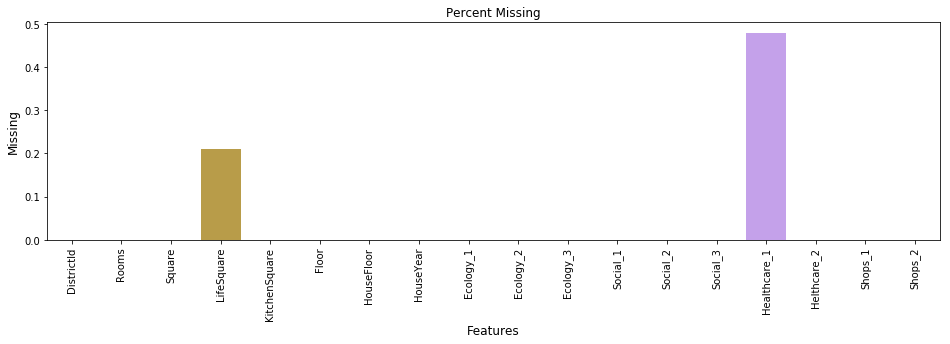

In [13]:
import seaborn as sns

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Удалим Healthcare_1
# Заполним LifeSquare

* ### 1.2 Feature engineering

**DistrictId**

In [14]:
X.DistrictId.nunique()

205

In [15]:
dict(X['DistrictId'].value_counts())

{'27': 851,
 '1': 652,
 '23': 565,
 '6': 511,
 '9': 294,
 '62': 247,
 '30': 228,
 '58': 179,
 '53': 174,
 '21': 165,
 '52': 143,
 '8': 142,
 '11': 129,
 '46': 119,
 '61': 118,
 '45': 116,
 '74': 114,
 '34': 111,
 '57': 107,
 '44': 104,
 '101': 97,
 '99': 97,
 '47': 97,
 '13': 97,
 '7': 92,
 '48': 90,
 '94': 89,
 '29': 89,
 '41': 87,
 '3': 82,
 '84': 80,
 '28': 79,
 '22': 78,
 '2': 78,
 '25': 77,
 '85': 76,
 '93': 73,
 '90': 72,
 '37': 72,
 '96': 71,
 '59': 67,
 '75': 66,
 '26': 65,
 '128': 64,
 '12': 64,
 '88': 64,
 '66': 62,
 '67': 61,
 '17': 59,
 '55': 58,
 '39': 57,
 '10': 56,
 '105': 55,
 '31': 55,
 '18': 51,
 '111': 49,
 '119': 49,
 '0': 48,
 '78': 46,
 '91': 44,
 '124': 43,
 '63': 43,
 '129': 43,
 '42': 42,
 '79': 42,
 '113': 41,
 '109': 41,
 '77': 40,
 '54': 37,
 '38': 36,
 '15': 36,
 '24': 35,
 '56': 34,
 '5': 34,
 '32': 34,
 '103': 33,
 '123': 32,
 '19': 31,
 '80': 31,
 '83': 31,
 '33': 31,
 '138': 29,
 '69': 29,
 '130': 29,
 '64': 28,
 '87': 27,
 '86': 27,
 '108': 27,
 '70': 

# 2. Очистка данных

In [16]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        #Square
        #X.loc[X['Square'] < 16, 'Square'] = 3
        X.loc[(X['Square'] < 8) & (X['LifeSquare'] > X['Square']) & (X['LifeSquare'] > 10),'Square']=X['LifeSquare']+self.medians['KitchenSquare']  
        X.loc[(X['Square'] < 8) & (X['LifeSquare'] > X['Square']) & (X['LifeSquare'] <= 10),'Square']=X['LifeSquare']*10+self.medians['KitchenSquare'] 
        X.loc[(X['Square'] < 8) & (X['LifeSquare'] <= X['Square']),'Square']=X['Square']*10 
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > 5, 'Rooms'] = round(self.medians['Rooms']) # !!! медиана посчитана на трейне !!!
        
        #room square
        X['RoomSquare']=X['Square']/(X['Rooms']+2)
        # Rooms
        #X['mRooms'] = round(self.medians['Rooms'])
        #X['mSquare'] = round(self.medians['Square'])
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        X.loc[(X['RoomSquare']<8) & (X['Rooms']>1) & (X['RoomSquare']<X['KitchenSquare']),'Rooms'] = 1
        X.loc[(X['RoomSquare']<5) & (X['Rooms']>1) ,'Rooms'] = 1
        X['RoomSquare']=X['Square']/(X['Rooms']+2)
        
        # KitchenSquare
        #X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        #X.loc[(X['KitchenSquare'] > X['Square']) & (X['Square']>10), 'KitchenSquare'] = X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] / 10  # можно median
        
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[(X['Square']*0.6 < X['KitchenSquare'] )  & (X['KitchenSquare']>10),'KitchenSquare'] =  self.medians['KitchenSquare']
        
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['Floor'] > X['HouseFloor'],'HouseFloor_outlier']= X['Floor']
        X.loc[X['HouseFloor_outlier'] > 0,'Floor']=X['HouseFloor']
        X.loc[X['HouseFloor_outlier'] > 0,'HouseFloor']=X['HouseFloor_outlier']
        X.loc[X['HouseFloor_outlier'] > 0,'HouseFloor_outlier']=1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        #X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        #X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        X.loc[X['HouseYear'] < 1900, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = 1900
        
        # Healthcare_1
        #if 'Healthcare_1' in X.columns:
        #    X.drop('Healthcare_1', axis=1, inplace=True)
        X['Healthcare_nan'] = X['Healthcare_1'].isna() * 1 
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = self.medians['Healthcare_1'] 
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        #X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        #X.loc[(X['LifeSquare']<10) & (X['LifeSquare']>0),'LifeSquare']=X['LifeSquare']*10
        X.loc[(X['LifeSquare']<10) & (X['LifeSquare']>0),'LifeSquare']=X['Square']- X[ 'KitchenSquare'] - X[ 'RoomSquare']
        #X.loc[(X['LifeSquare']>X['Square']) & (X['Square']>10),'LifeSquare']=X['Square']- X[ 'KitchenSquare'] - X[ 'RoomSquare']
        
        return X
        

In [17]:
imputer = FeatureImputer()

imputer.fit(X) # расчет медиан

X = imputer.transform(X)
X_final = imputer.transform(X_final)

# 3. Feature engineering

In [18]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.Years_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = 0
        self.med_price_by_yeardistrict = 0
        self.med_price_by_floordistrict = 0
        self.med_price_by_floor_year = 0
        self.med_room_by_distric = 0
        self.med_square_by_distric = 0
        self.med_kitchen_by_distric = 0
        self.med_health_by_distric = 0
        self.med_price_by_healthdistrict = 0
        self.med_price_by_socialdistrict = 0
        self.med_price_by_ecologydistrict = 0
        self.med_price_by_shopsdistrict = 0
        self.med_pricem2_by_distric = 0
        self.med_pricem2_by_roomdistric = 0
        
    def fit(self, X, y=None):
            
        X = X.copy()
        
        #medians
        self.medians = X.median()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 40]  ## Если вы этого не сделаете, то на Leaderboard-е улетите в самый низ (>100 места, R2 ~ 0.65),
                                            ## Хотя на локальной валидации скор вырастет
        
        self.DistrictId_counts = dict(district)
        
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            self.med_price_by_district=0
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                        rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        if y is not None:
            df['Price'] = y.values
            df['RoomPrice'] =  df['RoomSquare']*df['Price']/df['Square']
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            df = self.year_to_cat(df)
            #years = df['year_cat'].value_counts()
            #years = years[years > 40] 
            #df.loc[~df['year_cat'].isin(years.keys().tolist())] = np.nan
            
            self.med_pricem2_by_roomdistric=0
            self.med_pricem2_by_roomdistric = df.groupby(['DistrictId_popular', 'year_cat'], as_index=False).agg({'RoomPrice':'median'}).\
                                        rename(columns={'RoomPrice':'MedPriceByRoomDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        #df['MedPriceByFloorYear']=0
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            
            #years = df['year_cat'].value_counts()
            #years = years[years > 40] 
            #df.loc[~df['year_cat'].isin(years.keys().tolist())] = np.nan
        
            self.med_price_by_floor_year=0
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            #years = df['year_cat'].value_counts()
            #years = years[years > 40] 
            #df.loc[~df['year_cat'].isin(years.keys().tolist())] = np.nan
            
            self.med_price_by_yeardistrict=0
            self.med_price_by_yeardistrict = df.groupby(['DistrictId_popular', 'year_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByYearDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        if y is not None:
            df['Price'] = y.values
            df['M2Price'] = df['Price']/df['Square']
            #df['DistrictId_popular'] = df['DistrictId'].copy()
            #df = self.year_to_cat(df)
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_floordistrict=0
            self.med_price_by_floordistrict = df.groupby(['DistrictId_popular', 'floor_cat'], as_index=False).agg({'M2Price':'median'}).\
                                            rename(columns={'M2Price':'MedPriceByFloorDistrict',
                                                           'DistrictId_popular': 'DistrictId'})

        if y is not None:
            df['Price'] = y.values
            
            #df['DistrictId_popular'] = df['DistrictId'].copy()
            df = self.health_to_cat(df)
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            self.med_price_by_healthdistrict=0
            self.med_price_by_healthdistrict = df.groupby(['DistrictId_popular', 'health_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByHealthDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
        
        if y is not None:
            df['Price'] = y.values
            df['M2Price'] = df['Price']/df['Square']
            #df['DistrictId_popular'] = df['DistrictId'].copy()
            df = self.social_to_cat(df)
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            self.med_price_by_socialdistrict=0
            self.med_price_by_socialdistrict = df.groupby(['DistrictId_popular', 'social_cat'], as_index=False).agg({'M2Price':'median'}).\
                                            rename(columns={'M2Price':'MedPriceBySocialDistrict',
                                                           'DistrictId_popular': 'DistrictId'})

        if y is not None:
            df['Price'] = y.values
            df['M2Price'] = df['Price']/df['Square']
            #df['DistrictId_popular'] = df['DistrictId'].copy()
            df = self.ecology_to_cat(df)
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            self.med_price_by_ecologydistrict=0
            self.med_price_by_ecologydistrict = df.groupby(['DistrictId_popular', 'ecology_cat'], as_index=False).agg({'M2Price':'median'}).\
                                            rename(columns={'M2Price':'MedPriceByEcologyDistrict',
                                                           'DistrictId_popular': 'DistrictId'})

        if y is not None:
            df['Price'] = y.values
            #df['M2Price'] = df['Price']/df['Square']
            #df['DistrictId_popular'] = df['DistrictId'].copy()
            #df = self.ecology_to_cat(df)
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            self.med_price_by_shopsdistrict=0
            self.med_price_by_shopsdistrict = df.groupby(['DistrictId_popular', 'Shops_1'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByShopsDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        
        self.med_room_by_distric = round(df.groupby(['DistrictId'], as_index=False).agg({'Rooms':'median'}).\
                                    rename(columns={'Rooms':'mRooms'}))
        
        self.med_square_by_distric = round(df.groupby(['DistrictId'], as_index=False).agg({'Square':'median'}).\
                                    rename(columns={'Square':'mSquare'}))
        
        self.med_kitchen_by_distric = round(df.groupby(['DistrictId'], as_index=False).agg({'KitchenSquare':'median'}).\
                                    rename(columns={'KitchenSquare':'mKitchenSquare'}))
        
        self.med_health_by_distric = round(df.groupby(['DistrictId'], as_index=False).agg({'Healthcare_1':'median'}).\
                                    rename(columns={'Healthcare_1':'mHealth'}))
        
      #  if y is not None:
      #      df['Price'] = y.values
      #      df['M2Price'] = df['Price']/df['Square']
      #      self.med_pricem2_by_distric = round(df.groupby(['DistrictId'], as_index=False).agg({'M2Price':'median'}).\
      #                              rename(columns={'M2Price':'mM2Price'}))

        if y is not None:
            df['Price'] = y.values
            df['M2Price'] = df['Price']/df['Square']
            #df['DistrictId_popular'] = df['DistrictId'].copy()
            df = self.year_to_cat(df)
            #years = df['year_cat'].value_counts()
            #years = years[years > 40] 
            #df.loc[~df['year_cat'].isin(years.keys().tolist())] = np.nan
            
            df.loc[~df['DistrictId'].isin(district.keys().tolist())] = np.nan
            self.med_pricem2_by_distric=0
            self.med_pricem2_by_distric = df.groupby(['DistrictId', 'year_cat'], as_index=False).agg({'M2Price':'median'}).\
                                            rename(columns={'M2Price':'MedM2PriceByYearDistrict'})
            
        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        #X['mRooms'] = X.groupby(['DistrictId'], as_index=False).agg({'Rooms':'median'})  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        X = self.health_to_cat(X)   # + столбец health_cat
        X = self.social_to_cat(X)   # + столбец social_cat
        X = self.ecology_to_cat(X)   # + столбец ecology_cat
        

        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        #X['MedPriceByRoomDistrict'].fillna(0, inplace=True)
          
        if self.med_pricem2_by_roomdistric is not None:
            X = X.merge(self.med_pricem2_by_roomdistric, on=['DistrictId', 'year_cat'], how='left')
        #X['MedPriceByDistrict'].fillna(0, inplace=True)
        
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        #X['MedPriceByFloorYear'].fillna(0, inplace=True)
        
        if self.med_price_by_yeardistrict is not None:
            X = X.merge(self.med_price_by_yeardistrict, on=['DistrictId', 'year_cat'], how='left')
        #X['MedPriceByYearDistrict'].fillna(0, inplace=True)
        
        if self.med_price_by_floordistrict is not None:
            X = X.merge(self.med_price_by_floordistrict, on=['DistrictId', 'floor_cat'], how='left')
        #X['MedPriceByFloorDistrict'].fillna(0, inplace=True)
        
        if self.med_price_by_healthdistrict is not None:
            X = X.merge(self.med_price_by_healthdistrict, on=['DistrictId', 'health_cat'], how='left')
        #X['MedPriceByHealthDistrict'].fillna(0, inplace=True)

        if self.med_price_by_socialdistrict is not None:
            X = X.merge(self.med_price_by_socialdistrict, on=['DistrictId', 'social_cat'], how='left')
        #X['MedPriceBySocialDistrict'].fillna(0, inplace=True)

        
        if self.med_price_by_ecologydistrict is not None:
            X = X.merge(self.med_price_by_ecologydistrict, on=['DistrictId', 'ecology_cat'], how='left')
        #X['MedPriceByEcologyDistrict'].fillna(0, inplace=True)
        
        if self.med_price_by_shopsdistrict is not None:
            X = X.merge(self.med_price_by_shopsdistrict, on=['DistrictId', 'Shops_1'], how='left')
        #X['MedPriceByShopsDistrict'].fillna(0, inplace=True)
        
        if self.med_room_by_distric is not None:
            X = X.merge(self.med_room_by_distric, on=['DistrictId'], how='left')
        #X['mRooms'].fillna(round(self.medians['Rooms']), inplace=True)
        
        if self.med_square_by_distric is not None:
            X = X.merge(self.med_square_by_distric, on=['DistrictId'], how='left')
        #X['mSquare'].fillna(round(self.medians['Square']), inplace=True)
        
        if self.med_kitchen_by_distric is not None:
            X = X.merge(self.med_kitchen_by_distric, on=['DistrictId'], how='left')
        #X['mKitchenSquare'].fillna(round(self.medians['KitchenSquare']), inplace=True)
        
        if self.med_health_by_distric is not None:
            X = X.merge(self.med_health_by_distric, on=['DistrictId'], how='left')
        X['mHealth'].fillna(round(self.medians['Healthcare_1']), inplace=True)
        #X['Healthcare_1'].fillna(round(X['mHealth']), inplace=True)
        
        #if self.med_pricem2_by_distric is not None:
        #    X = X.merge(self.med_pricem2_by_distric, on=['DistrictId'], how='left')
        #X['mM2Price'].fillna(0, inplace=True)
        
        if self.med_pricem2_by_distric is not None:
            X = X.merge(self.med_pricem2_by_distric, on=['DistrictId', 'year_cat'], how='left')
        X['MedM2PriceByYearDistrict'].fillna(0, inplace=True)
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = X['mKitchenSquare']
        X.loc[(X['Square']*0.5 < X['KitchenSquare'] )  & (X['KitchenSquare']>10),'KitchenSquare'] =  X['mKitchenSquare']
        #X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] / 10  # можно median
        
        X.loc[(X['LifeSquare'] <= 0) | (X['LifeSquare_nan']==1),'LifeSquare']=X['Square']-X['KitchenSquare'] - 3        
        #X.loc[X['LifeSquare']<10,'LifeSquare']=X['LifeSquare']*10
        X.loc[X['LifeSquare']<10,'LifeSquare']=X['Square']-X['KitchenSquare'] - 3 
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = 1
        
        X.loc[X['Floor'] == 1, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >1) & (X['Floor'] <= 3), 'floor_cat'] = 2
        X.loc[(X['Floor'] >3) & (X['Floor'] <= 5), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 10), 'floor_cat'] = 4
        X.loc[(X['Floor'] > 10) & (X['Floor'] <= 15), 'floor_cat'] = 5
        X.loc[(X['Floor'] > 15) & (X['Floor'] <= 20), 'floor_cat'] = 6
        X.loc[(X['Floor'] > 20) & (X['Floor'] <= 25), 'floor_cat'] = 7
        X.loc[(X['Floor'] > 25) & (X['Floor'] <= 30), 'floor_cat'] = 8
        X.loc[X['Floor'] > 35, 'floor_cat'] = 9
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        #X['year_cat'] = 8
        
        #X.loc[X['HouseYear'] <= 1928, 'year_cat'] = 1
        #X.loc[(X['HouseYear'] > 1928) & (X['HouseYear'] <= 1940), 'year_cat'] = 2
        #X.loc[(X['HouseYear'] > 1940) & (X['HouseYear'] <= 1945), 'year_cat'] = 3
        #X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1972), 'year_cat'] = 4
        #X.loc[(X['HouseYear'] > 1972) & (X['HouseYear'] <= 1986), 'year_cat'] = 5
        #X.loc[(X['HouseYear'] > 1987) & (X['HouseYear'] <= 2006), 'year_cat'] = 6
        #X.loc[(X['HouseYear'] > 2007) & (X['HouseYear'] <= 2012), 'year_cat'] = 7
        #X.loc[(X['HouseYear'] > 2012), 'year_cat'] = 8
        X['year_cat'] = round((X['HouseYear']-1900)/1)
            
        return X
            
    @staticmethod
    def health_to_cat(X):
        
        X['health_cat'] = np.nan
        
        X['health_cat'] = round(X['Healthcare_1']/1000)
        
        #X.loc[X['Healthcare_1'] <= 1000, 'health_cat'] = 1
        #X.loc[(X['Healthcare_1'] > 2000) & (X['Healthcare_1'] <= 3000), 'health_cat'] = 2
        #X.loc[(X['Healthcare_1'] > 3000) & (X['Healthcare_1'] <= 4000), 'health_cat'] = 3
        #X.loc[(X['Healthcare_1'] > 4000) & (X['Healthcare_1'] <= 5000), 'health_cat'] = 4
        #X.loc[(X['Healthcare_1'] > 5000) & (X['Healthcare_1'] <= 6000), 'health_cat'] = 5
        #X.loc[(X['Healthcare_1'] > 6000) & (X['Healthcare_1'] <= 7000), 'health_cat'] = 6
        #X.loc[(X['Healthcare_1'] > 7000) & (X['Healthcare_1'] <= 8000), 'health_cat'] = 7
        #X.loc[(X['Healthcare_1'] > 8000), 'health_cat'] = 8

        return X
    
    @staticmethod
    def social_to_cat(X):
        
        X['social_cat'] = round(X['Social_1']/10)
        

        return X
    
    @staticmethod
    def square_to_cat(X):
        
        X['square_cat'] = round(X['Square']/10)
        

        return X  
    
    @staticmethod
    def ecology_to_cat(X):
        
        X['ecology_cat'] = round(X['Ecology_1']*100)
        

        return X        
    
    

In [19]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)


In [20]:
X.head(2)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,MedPriceByFloorDistrict,MedPriceByHealthDistrict,MedPriceBySocialDistrict,MedPriceByEcologyDistrict,MedPriceByShopsDistrict,mRooms,mSquare,mKitchenSquare,mHealth,MedM2PriceByYearDistrict
0,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.08904,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,900.0,0.000000
1,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.00007,1,...,4473.328005,170601.391312,4335.433207,4335.433207,172138.913524,2.0,48.0,8.0,900.0,4567.491245


In [21]:
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                  'Rooms_outlier', #'HouseFloor_outlier', #'HouseYear_outlier', #'LifeSquare_nan',
                   'HouseFloor', 
                   'HouseYear',
                   #'floor_cat',
                   'year_cat',
'MedPriceByDistrict',
'MedPriceByFloorYear',
'MedPriceByYearDistrict',
'MedPriceByFloorDistrict',
'MedPriceByHealthDistrict',
'MedPriceBySocialDistrict',
'MedPriceByEcologyDistrict', #'ecology_cat',
'MedPriceByShopsDistrict',
'MedM2PriceByYearDistrict',
'MedPriceByRoomDistrict',
                  'DistrictId_count', 
                   'new_district', 
                   'Ecology_2', 
                   'Ecology_3', 
                   'Shops_2',
                   #'mRooms',
                   'RoomSquare',
                   #'mSquare',
                   'mKitchenSquare', #'Healthcare_1'
                  ] #, 'mHealth','Healthcare_1','Healthcare_nan' 


X = X[remain_features]
X_final = X_final[remain_features]

# 4. Модель

In [22]:
model = LGBMRegressor(max_depth=7,
                             min_samples_leaf=10,
                             n_estimators=150,
                             random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.789 +- 0.017


In [23]:
# Обучаю модель на всем трейне
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=7,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=10,
              min_split_gain=0.0, n_estimators=150, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

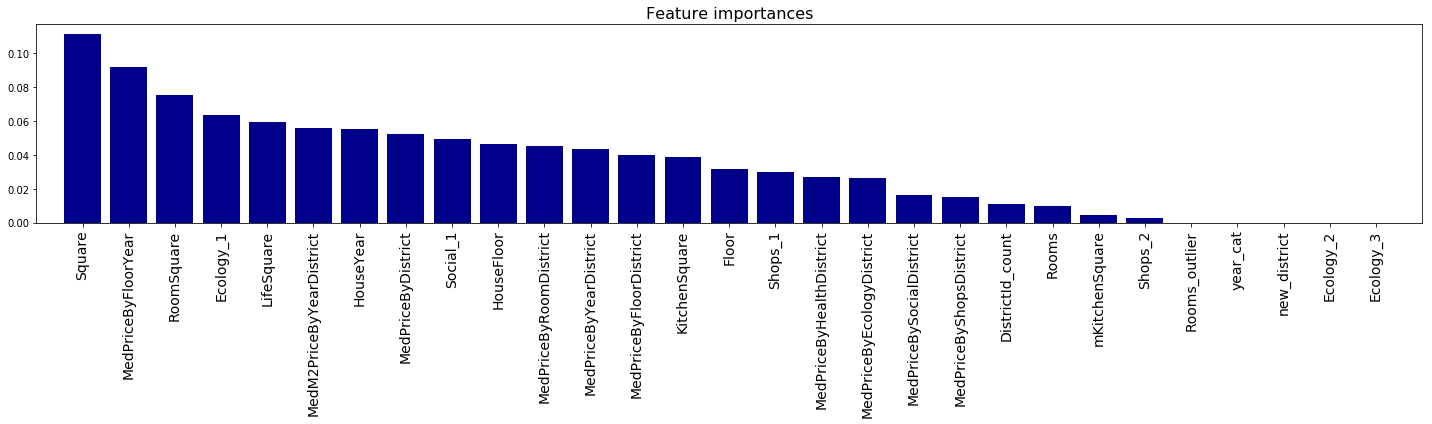

In [24]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [25]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,172457.746290
1,15856,230869.578363
2,5480,236300.164060
3,15664,262471.676224
4,14275,147854.345291


In [26]:
preds_final.shape

(5000, 2)